# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [24]:
import twitter

CONSUMER_KEY = "03Ai0vQvQ5cbkf2PqMLDKqhmE"
CONSUMER_SECRET = "ROGs6elMuhmnfTuky25EhoNvvTbRT9uXe7c4r2GEw6LRQpxopE"

ACCESS_TOKEN_KEY = "4310324793-f8UuXkQui6m0bpwlt9Us3O8LQQMUVebBF8KCs6F"
ACCESS_TOKEN_SECRET = "oySIWDx2F55bTyVNEqvhi5Qmc2ZQUlKtxVrwthB9IQrkQ"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit=True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [25]:
import re
import os
import json

catalog = "downloaded_tweets"
if not os.path.exists(catalog):
    os.makedirs(catalog)
      
def get_user_tweets(user_id): # we will save tweets in file in case of errors and internet problems
    """returns list of tweets as dicts"""
    # your code here
    global file_name
    file_name = catalog + '/' + str(user_id)
    
    user_tweets = []
    
    if os.path.exists(file_name): # if this user has already been processed then download tweets from file
        with open(file_name) as f:
            for line in f:
                try:
                    user_tweets.append(json.loads(line))
                except:
                    continue
    else: # if this user is a new user 
        try:
            statuses = api.GetUserTimeline(user_id=user_id, count=200, include_rts ='false', exclude_replies ='true') # exclude retweets and replies
            for s in statuses:
                if (not s.urls) and (s.media is None): # do not include url and media (photo and video)
                    s.text = re.sub(r"http\S+", "", s.text) # if there is other links in tweets
                    user_tweets.append({'lang': s.lang, 
                         'favorited': s.favorited, 
                         'truncated': s.truncated, 
                         'text': s.text, 
                         'created_at': s.created_at, 
                         'retweeted': s.retweeted, 
                         'source': s.source, 
                         'user': {'id': s.user.id}, 
                         'id': s.id})
            f = open(file_name, 'a') # save new user in file        
            for tweet in user_tweets:
                tweet['user'] = tweet['user']['id'] 
                f.write(json.dumps(tweet)+'\n')
            f.close()           
        except twitter.TwitterError:
            print 'error'
    return user_tweets

In [15]:
#get_user_tweets(2330149164)

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [26]:
def get_words(text):
    """returns list of words"""
    # your code here
    text = text.lower()
    words = []
    for w in text.split():
        w = re.sub(r'[!\?@.,;:\-%\#\(\)\$\\/\'\"\*\+\[\]<>_&\d]', '', w) # delete symbols
        if w: # if w is not empty string
            words.append(w)
    return words

In [17]:
#get_words(u'😏 ')

Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [4]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [27]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def get_tokens(words):
    """returns list of tokens"""
    # your code here
    tokens = []
    stop_words = set(stopwords.words('english')) # get stop words
    wnl = WordNetLemmatizer()
    for w in words:
        w = wnl.lemmatize(w) # normalize
        if (w not in stop_words) and w.isalpha(): # exclude smiles
            tokens.append(w)
    return tokens

Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [28]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(get_words(tweet))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [29]:
def count_tokens(user_tokens): # create dictionary to count user tokens
    tokens_amt = {}
    for token in user_tokens:
        if token in tokens_amt:
            tokens_amt[token] += 1
        else:
            tokens_amt[token] = 1
    return tokens_amt

In [32]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # your code here
    # save intermediate result
    users = []
    user_tokens_amt = [] # list of dictionaries
    
    for user in df_users['uid']:
        user_tokens = [] # list of user tokens
        user_tweets = get_user_tweets(user) # get user tweets
        for tweet in user_tweets:
            user_tokens += get_tweet_tokens(tweet['text'])
        if user_tokens: # if list is not empty and we have user tokens
            user_tokens_amt.append(count_tokens(user_tokens))
            users.append(user)
            
        if len(users) & 127 == 0:
            print len(users)
         
    return users, user_tokens_amt

In [33]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer

"""v = DictVectorizer()
D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz': 1}]
print v.fit_transform(D).toarray()
print v.get_feature_names()"""

TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex]) 

users, users_tokens = collect_users_tokens(df_users) 

error
error
128
error
256
error
384
error
384
384
error
error
error
error
error
error
512
error
error
error
640
640
error
error
error
error
768
error
error
896
error
error
error
error
error
error
1024
1024
error
error
error
error
error
error
1152
error
error
error
error
error
error
error
1280
error
error
error
error
1408
error
error
error
1536
1536
error
1664
error
1792
error
error
error
error
error
error
error
error
1920
error
error
2048
error
error
error
2176
error
error
error
error
error
error
2304
error
error
error
error
2432
error
error
error
error
error
error
error
2560
error
2560
error
error
error
error
2688
error
error
error
error
error
2816
error
error
error
2944
error
error
error
3072
error
error
error
error
3200
error
error
error
error
error
error
error
error
3328
error
3328
3328
error
error
error
error
3456
error
error
3584
error
error
error
error
error
error
3712
3712
error
error
error
error
3840
error
error
error
error
error
3968
3968
error
error
error
4096
error
4224
err

In [35]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)


[u'aa', u'aaa', u'aaaa', u'aaaaa', u'aaaaaa', u'aaaaaaa', u'aaaaaaaa', u'aaaaaaaaa', u'aaaaaaaaaa', u'aaaaaaaaaaa', u'aaaaaaaaaaaa', u'aaaaaaaaaaaaa', u'aaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssss', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaalex', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhh', u'aaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhh', u'aaaaaaaaaaaaaaaaaaaaaaa

IOError: [Errno 2] No such file or directory: 'files/out_4.dat.npz'

In [38]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [47]:
def most_popular_tokens(users_tokens, N):
    """Find N most popular tokens and return string of this tokens"""
    all_tokens = {}
    for user_tokens in users_tokens:
        for token in user_tokens:
            if token in all_tokens:
                all_tokens[token] += user_tokens[token]
            else:
                all_tokens[token] = 1
    # sort all_tokens on items, result - list of tuples
    sorted_tokens = sorted(all_tokens.items(), key=lambda item: item[1], reverse=True) 
    # normalize frequency and take first N tokens
    popular_tokens = [(key[0], key[1]/sorted_tokens[N-1][1]) for key in sorted_tokens[0:N]]
    popular_tokens_string = ''
    for token in popular_tokens:
        for t in xrange(token[1]):
            popular_tokens_string += token[0] + ' '
    return popular_tokens_string

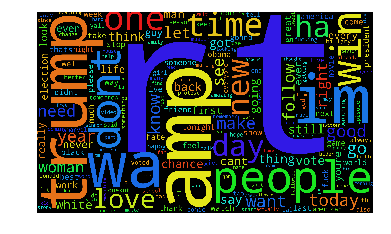

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def draw_tag_cloud(users_tokens):
    """Draws tag cloud of found tokens"""
    popular_tokens_string = most_popular_tokens(users_tokens, 500) 
    wordcloud = WordCloud(font_path=None, stopwords=STOPWORDS, background_color='black', width=5000, height=3000).generate(popular_tokens_string)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    return

draw_tag_cloud(users_tokens)